# The Oxford-IIIT Pet Dataset
- https://www.robots.ox.ac.uk/~vgg/data/pets/
- 37개 카테고리의 개, 고양이 품종 데이터셋. 각 클래스 별로 대략 200여장의 이미지를 제공한다.
- 파일명에 품종이 포함되어 있어 classification 데이터셋을 만들 수 있다.
- 3686개 이미지에대한 annotation 파일을 제공한다.
    - bounding box는 각 pet의 얼굴을 가리킨다. 

In [1]:
# library import
import os
 
import re
import random
# xml parsing library - beautifulsoup 써도 됨
import xml.etree.ElementTree as et
from PIL import Image
 
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
 
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


# Oxford Pet Dataset
- 파일명
    - 품종명_번호.jpg
    - 대문자로 시작: 고양이, 소문자로 시작: 개
    - Egyptian_Mau_1.jpg, american_bulldog_10.jpg

### 데이터셋 다운로드

In [2]:
import gdown
url = 'https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gXqmWrxJqdp_luNKZmv81vY5cjFLuTdT
To: /content/oxford_pet.zip
811MB [00:04, 183MB/s]


'oxford_pet.zip'

In [3]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [4]:
## 압축이 풀린 directory 확인
!ls -al oxford_pet

total 304
drwxr-xr-x 4 root root   4096 Sep 17 07:34 .
drwxr-xr-x 1 root root   4096 Sep 17 07:34 ..
drwxr-xr-x 4 root root   4096 Sep 17 07:34 annotations
drwxr-xr-x 2 root root 299008 Sep 17 07:34 images


In [5]:
# 경로 설정
base_dir = '/content/oxford_pet'   # 데이터셋 기본경로
image_dir = os.path.join(base_dir, 'images')   # image 디렉토리 경로
bbox_dir = os.path.join(base_dir, 'annotations', 'xmls')   # annotation 파일경로
print(image_dir, bbox_dir)

/content/oxford_pet/images /content/oxford_pet/annotations/xmls


In [ ]:
os.listdir(image_dir)

['wheaten_terrier_17.jpg',
 'Bengal_119.jpg',
 'great_pyrenees_179.jpg',
 'Russian_Blue_120.jpg',
 'english_cocker_spaniel_84.jpg',
 'Egyptian_Mau_153.jpg',
 'yorkshire_terrier_71.jpg',
 'Ragdoll_6.jpg',
 'British_Shorthair_36.jpg',
 'american_pit_bull_terrier_10.jpg',
 'Siamese_143.jpg',
 'japanese_chin_68.jpg',
 'keeshond_114.jpg',
 'Birman_179.jpg',
 'newfoundland_141.jpg',
 'english_cocker_spaniel_200.jpg',
 'japanese_chin_95.jpg',
 'Birman_71.jpg',
 'Bengal_85.jpg',
 'British_Shorthair_114.jpg',
 'saint_bernard_137.jpg',
 'havanese_38.jpg',
 'yorkshire_terrier_42.jpg',
 'Persian_233.jpg',
 'shiba_inu_20.jpg',
 'scottish_terrier_176.jpg',
 'shiba_inu_26.jpg',
 'yorkshire_terrier_98.jpg',
 'havanese_54.jpg',
 'boxer_37.jpg',
 'staffordshire_bull_terrier_111.jpg',
 'beagle_67.jpg',
 'wheaten_terrier_7.jpg',
 'Russian_Blue_262.jpg',
 'British_Shorthair_181.jpg',
 'american_bulldog_106.jpg',
 'Maine_Coon_72.jpg',
 'Birman_127.jpg',
 'Russian_Blue_30.jpg',
 'leonberger_199.jpg',
 'pomer

In [6]:
os.path.splitext('abc.jpg')

('abc', '.jpg')

In [7]:
for file in os.listdir(image_dir):
    if os.path.splitext(file)[-1] == '.jpg':
        print(file)
        break

wheaten_terrier_17.jpg


In [8]:
# 이미지 파일명 조회 comprehension
# 확장자가 .jpg인 파일들만 list에 담기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))
 
image_files[:3]

7390


['wheaten_terrier_17.jpg', 'Bengal_119.jpg', 'great_pyrenees_179.jpg']

In [9]:
#annotation 파일 경로
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))
bbox_files[:3]

3686


['japanese_chin_121.xml', 'Egyptian_Mau_195.xml', 'basset_hound_145.xml']

In [10]:
# 이미지 파일중 RGB가 아닌 이미지 파일과 그 파일에 대한 annotation파일 제거
remove_image_cnt = 0   # 이미지 몇 장 삭제했는지 저장할 변수

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)   # 이미지 파일의 전체 경로
    bbox_file = os.path.splitext(image_file)[0]+'.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)   # annotation 파일의 전체 경로
    
    image = Image.open(image_path)   # pillow 라이브러리의 클래스 Image로 이미지 읽어오기
    image_mode = image.mode   # Image.mode -> 색공간을 반환(RGB, L-흑백, P-RGB아닌 컬러(gif), RGBA)
    if image_mode != 'RGB':
        image = np.asarray(image)
        print(image_file, image_mode, image.shape)

        os.remove(image_path)   # 이미지 삭제
        remove_image_cnt += 1
        if os.path.isfile(bbox_path):   # annotation 삭제
            print(bbox_path)
            os.remove(bbox_path)

Egyptian_Mau_186.jpg RGBA (275, 183, 4)
staffordshire_bull_terrier_22.jpg L (500, 364)
Egyptian_Mau_129.jpg L (325, 299)
/content/oxford_pet/annotations/xmls/Egyptian_Mau_129.xml
Egyptian_Mau_139.jpg P (250, 350)
Egyptian_Mau_191.jpg P (214, 300)
Egyptian_Mau_145.jpg P (188, 216)
Abyssinian_34.jpg P (202, 250)
Egyptian_Mau_167.jpg P (275, 183)
Egyptian_Mau_177.jpg P (175, 246)
Abyssinian_5.jpg RGBA (150, 200, 4)
staffordshire_bull_terrier_2.jpg L (282, 500)
Egyptian_Mau_14.jpg RGBA (800, 582, 4)


In [11]:
remove_image_cnt

12

In [12]:
# 삭제후 image, annotation 파일 목록 다시만들기
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']

### class dictionary 생성

In [13]:
# 클래스 딕셔너리 리스트로 만들기
class_list = set()   # set: 중복 허용 안 함
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]   # 확장자 제거
    class_name = re.sub('_\d+', '', file_name)    # _정수 제거
    class_list.add(class_name)    
class_list = list(class_list) 
class_list.sort()  
print(len(class_list), class_list[:3])

37 ['Abyssinian', 'Bengal', 'Birman']


In [14]:
# 리스트 딕셔너리로 만들기: class->index로 반환하는 것.
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [15]:
class2idx['Birman']

2

# train/validation 데이터셋 만들기

## TFRecord 만들기

In [16]:
IMG_SIZE = 224   # input shape
N_BBOX = len(bbox_files)   # 총 데이터 개수
N_TRAIN = 3000   # train 데이터 개수
N_VAL = N_BBOX - N_TRAIN    # val 데이터 개수

In [17]:
## TFRecord 저장할 directory 생성
tfr_dir = os.path.join(base_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'oxford_train.tfr')   # train set을 담을 tfr 파일 경로
tfr_val_dir = os.path.join(tfr_dir, 'oxford_val.tfr')  # val set을 담을 tfr 파일 경로

In [18]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [19]:
# The following functions can be used to convert a value to a type compatible with tf.Example.
 
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
 
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [20]:
# train, validation 데이터셋의 index 설정

# 데이터 섞기
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list) 
# 분할
train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [21]:
print(len(train_idx_list), len(val_idx_list))
train_idx_list[:10], val_idx_list[:10]

3000 685


([1574, 1903, 3555, 3077, 560, 628, 502, 2998, 3213, 1643],
 [1719, 3640, 1073, 713, 2408, 2776, 791, 2946, 337, 1641])

In [22]:
np.array(bbox_files)[train_idx_list[:10]]

array(['american_bulldog_147.xml', 'boxer_133.xml',
       'Russian_Blue_125.xml', 'yorkshire_terrier_177.xml',
       'havanese_148.xml', 'newfoundland_144.xml',
       'staffordshire_bull_terrier_188.xml', 'yorkshire_terrier_133.xml',
       'pomeranian_156.xml', 'yorkshire_terrier_114.xml'], dtype='<U34')

In [23]:
# Train TFRecord 생성
for idx in train_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)    # annotation 파일 경로
 
    # xml tree구조 파싱
    tree = et.parse(bbox_path)   # xml 파일을 읽어와서 root element를 조회
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    #X, Y Center 좌표
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
 
    # 이미지의 width, height로 나눠서 normalization
    x = xc / width
    y = yc / height
    
    # bbox의 width와 height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
 
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)   # 이미지 로딩(pillow 타입)
    image = image.resize((IMG_SIZE, IMG_SIZE))   # (224, 224)로 리사이즈
    bimage = image.tobytes()   # bytes 타입으로 변환 (직렬화)
 

    # 품종 라벨 생성
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
    
    
    if file_name[0].islower():   # 개; 소문자, 고양이; 대문자로 시작
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    
    example = tf.train.Example(features=tf.train.Features(feature={
          'image': _bytes_feature(bimage),   # image 파일 자체
          'cls_num': _int64_feature(class_num),   # 품종 라벨(인코딩된)
          'bi_cls_num': _int64_feature(bi_cls_num),   # dog(0), cat(1) 이진 라벨
          'x': _float_feature(x),   # bbox 좌표 : center x좌표
          'y': _float_feature(y),   # bbox 좌표 : center y좌표
          'w': _float_feature(w),   # bbox 너비
          'h': _float_feature(h)    # bbox 높이
    }))
    writer_train.write(example.SerializeToString())

writer_train.close()

In [24]:
# Validation TFRecord 생성
for idx in val_idx_list:
    bbox_file = bbox_files[idx]
    bbox_path = os.path.join(bbox_dir, bbox_file)
 
    tree = et.parse(bbox_path)
    width = float(tree.find('./size/width').text)
    height = float(tree.find('.size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    xc = (xmin + xmax) / 2.
    yc = (ymin + ymax) / 2.
    x = xc / width
    y = yc / height
    w = (xmax - xmin) / width
    h = (ymax - ymin) / height
 
    file_name = os.path.splitext(bbox_file)[0]
    image_file = file_name + '.jpg'
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
 
    class_name = re.sub('_\d+', '', file_name)
    class_num = class2idx[class_name]
 
    if file_name[0].islower():
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    
    
    example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
    }))
    writer_val.write(example.SerializeToString())

writer_val.close()

# Localization 모델 학습

In [25]:
## Hyper Parameters
LEARNING_RATE = 0.0001
N_CLASS = len(class_list)
N_EPOCHS = 2
N_BATCH = 40
IMG_SIZE = 224

steps_per_epoch = N_TRAIN // N_BATCH   # 1 에폭 당 몇 번 학습(step 수)
validation_steps = int(np.ceil(N_VAL / N_BATCH))   # 1 에폭 당 몇 번 검증(step 수)

print(steps_per_epoch, validation_steps)

75 18


In [26]:
# TFRecord에 저장된 Dataset의 하나의 Data를 parsing하는 함수
def _parse_function(tfrecord_serialized):
    """
    [매개변수]
        tfrecord_serialized: parsing할 1개의 data (Serialized Example)
    [반환값] 
        튜플 (image, ground truth)
    """
    
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    # 이미지 Feature를 image data(Tensor)로 변환
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])   # 이미지 resize
    image = tf.cast(image, tf.float32)/255.
    
    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ground_truth = tf.stack([x, y, w, h], -1)   # tf.stack() = numpy concatenate()랑 동일한 기능. y값인 x,y,w,h를 하나의 배열로 묶음
    
    return image, ground_truth   # X, y return

In [27]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)   # TFRecordDataset을 생성 - tfr 파일경로

# num_parallel_calls: 병렬 처리. 변환 속도를 올려준다.
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)   # serialized example에서 X, y 추출

# prefetch(): 현재 step 학습하는 동안 다음 step에서 사용할 데이터를 미리 읽어오라는 설정
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [28]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

### Trainset의 데이터 읽어서 bounding box 확인

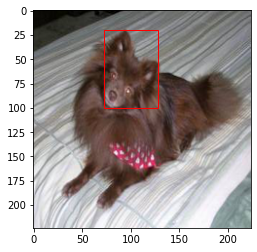

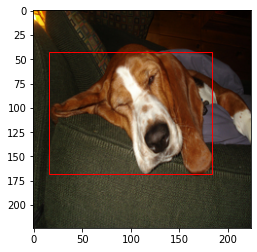

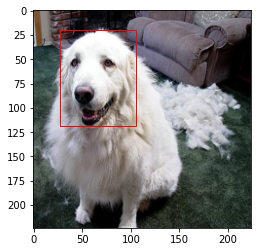

In [29]:
for image, gt in val_dataset.take(3):   # 3 배치 만큼 값 조회
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0] 
    y = gt[:,1] 
    w = gt[:,2] 
    h = gt[:,3] 
    xmin = x[0].numpy() - w[0].numpy()/2.   # 배치 40개 중 첫 번째 것만 가져오기
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE) 
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')   # matplotlib.patches - 도형 그려주는 함수 - Rectangel((xmin, ymin), w, h)
    plt.axes().add_patch(rect)   # axes에 사각형을 그리는 함수
    plt.imshow(image[0])
    plt.show()

## 모델 생성 및 학습


In [30]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [ ]:
def create_l_model():
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    model = keras.models.Sequential()
    model.add(resnet101v2)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(4, activation='sigmoid'))   # (x,y,w,h) 에측값 출력이라 원래 회귀 문제. 근데 x,y,w,h가 정규화돼있기 때문에 sigmoid로 출력값을 0~1로 맞춰준다
    return model

In [ ]:
model = create_l_model()
model.summary()

171327488/171317808 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_______________________________________________________

In [ ]:
# 모델 컴파일
## learning rate scheduing - 10 에폭마다 0.5로 줄임
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss="mse")

In [ ]:
# filepath = r'/content/drive/MyDrive/save_models/oxford_pet_localization_resnet101v2_model'
# mc_callback = keras.callbacks.ModelCheckpoint(filepath, 'val_loss',verbose=1, save_best_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[es_callback])

Epoch 1/2
75/75 [==============================] - 116s 2s/step - loss: 0.0084 - val_loss: 0.0131
Epoch 2/2
75/75 [==============================] - 118s 2s/step - loss: 0.0049 - val_loss: 0.0088


## 확인

In [31]:
# 미리학습한 모델 다운로드
import gdown  
url = 'https://drive.google.com/uc?id=1-46XMDhIrkBnvYKNN_VGlhPlyu-Bn3tF'
fname = 'oxford_pet_localization_resnet101.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-46XMDhIrkBnvYKNN_VGlhPlyu-Bn3tF
To: /content/oxford_pet_localization_resnet101.tar.gz
475MB [00:02, 190MB/s]


'oxford_pet_localization_resnet101.tar.gz'

In [32]:
!mkdir models

In [33]:
!tar -zxvf oxford_pet_localization_resnet101.tar.gz -C  models

./
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001
./assets/
./keras_metadata.pb
./saved_model.pb


In [34]:
# 저장된 모델 load
filepath = '/content/models'
saved_model = keras.models.load_model(filepath)

In [35]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

### Bounding Box 그리기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


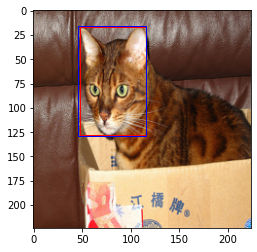

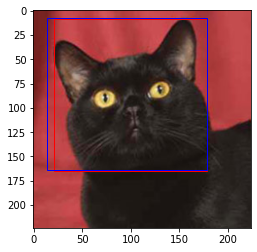

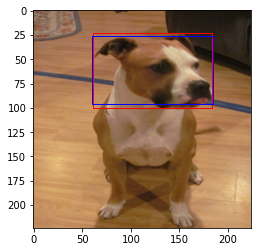

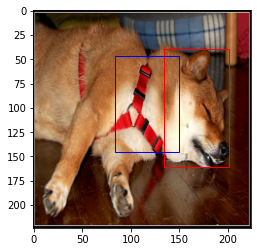

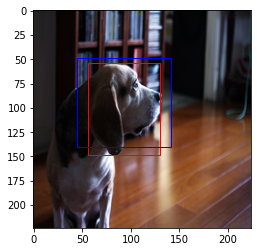

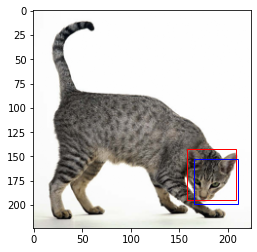

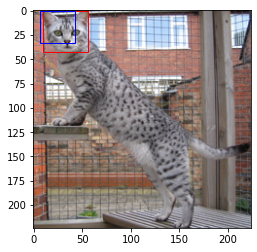

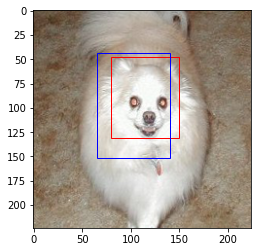

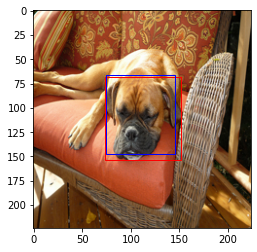

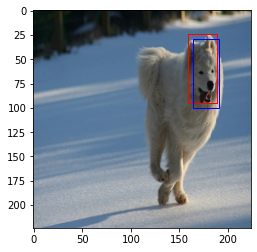

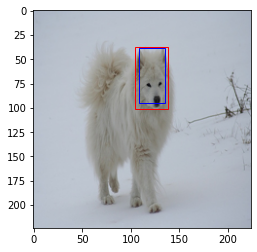

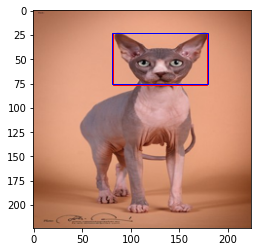

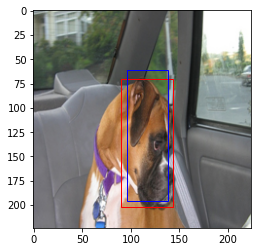

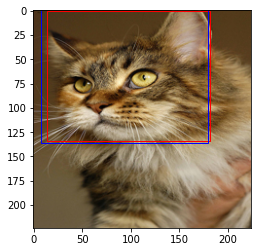

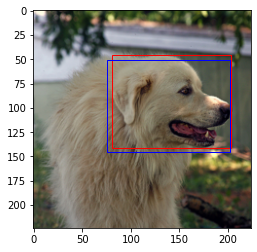

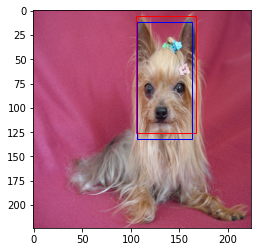

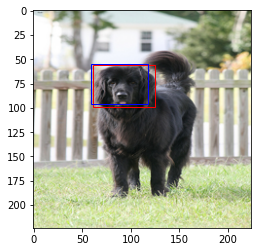

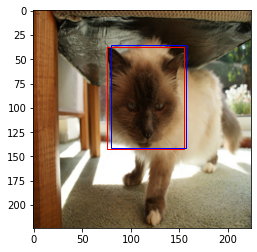

In [36]:
# 예측한 bounding box와 ground truth box를 image에 같이 표시
# 정답은 빨간색 box, 예측은 파란색 box
idx = 1
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):

    # ground truth bbox 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]

    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.

    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    # model의 예측 결과로 bbox 그리기
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    
    plt.imshow(val_data[idx])
    plt.show()
 


In [ ]:
N_VAL

685

### IoU확인하기

In [37]:
## Valiation set의 IOU 계산
avg_iou = 0   # 최종 평균 IoU 값을 저장할 변수
num_imgs = validation_steps   # 총 step 수(validation dataset에 대한) (18)

res = N_VAL % N_BATCH   # 685 % 40 -> 나머지가 있기 때문에 iou를 계산하기 위해 마지막 배치에서는 나머지를 데리고 돌아줘야 함. res = 마지막 배치의 데이터 수

for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = saved_model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]

    # 각 데이터 별 IoU 값을 계산
    for idx in range(N_BATCH):
        if(flag):   # 마지막 반복
            if idx == res:   # data index가 res(마지막 배치 개수)와 같다면: 마지막 배치의 모든 데이터에 대한 계산이 끝났다.
                flag = False
                break   # 반복문 빠져나온다.
        
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
 
        # gt bbox, pred bbox가 겹치지 않는 경우 체크
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        

        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
 
        # np.min((xmax, pred_xmax)): 교집합 박스의 xmax 값
        # np.max((xmin, pred_xmin)): 교집합 박스의 xmin 값
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))

        avg_iou += iou / N_VAL

print(avg_iou)

0.8103459212510764


# Classification을 추가하여 Multi-task Learning으로 Localization 학습하기

- **고양이/개 2개 class로 classification**

In [38]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow import keras

In [39]:
#tfrecord 파싱 함수(classification + localization)
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.float32)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    ground_truth = tf.stack([bi_cls_label, x, y, w, h], -1)   # [classification, location] --> shape =  (5,)
    
    return image, ground_truth

In [40]:
#Train Dataset 생성
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH, drop_remainder=True)

In [41]:
#Validation Dataset 생성
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

In [42]:
def create_cl_model():    
    # resnet101v2 전이학습을 이용 -> 이미지의 특징(feature map) 뽑아내기 ==> backbone
    resnet101v2 = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    gap = GlobalAveragePooling2D()(resnet101v2.output)

    # dog/cat 분류하는 path - 이진분류
    dense_b1_1 = Dense(256)(gap)
    bn_b1_2 = BatchNormalization()(dense_b1_1)
    relu_b1_3 = ReLU()(bn_b1_2)
    dense_b1_4 = Dense(64)(relu_b1_3)
    bn_b1_5 = BatchNormalization()(dense_b1_4)
    relu_b1_6 = ReLU()(bn_b1_5)
    output1 = Dense(2, activation='softmax', name='output1')(relu_b1_6)

    # 위치(x, y, w, h)를 추론하는 path
    dense_b2_1 = Dense(256)(gap)
    bn_b2_2 = BatchNormalization()(dense_b2_1)
    relu_b2_3 = ReLU()(bn_b2_2)
    dense_b2_4 = Dense(64)(relu_b2_3)
    bn_b2_5 = BatchNormalization()(dense_b2_4)
    relu_b2_6 = ReLU()(bn_b2_5)
    output2 = Dense(4, activation='sigmoid', name='output2')(relu_b2_6)
    
    concat = Concatenate(name='finaly_output')([output1, output2])
    return keras.Model(inputs=resnet101v2.input, outputs=concat)

In [43]:
model = create_cl_model()
model.summary()

171327488/171317808 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___________________________

In [44]:
keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [45]:
# Loss 함수 구현
# 매개변수 = (정답, 예측값)
# 반환값 = loss (오차)
def loss_fn(y_true, y_pred):
    # 정답 shape=(N, 5) / 예측 결과 shape=(N, 6)
    cls_labels = tf.cast(y_true[:,:1], tf.int64)   # 정답 분류라벨(label encoding)
    loc_labels = y_true[:,1:]   # 정답 위치(x,y,w,h)
    cls_preds = y_pred[:,:2]   # 예측 분류 라벨(0확률, 1확률)
    loc_preds = y_pred[:,2:]   # 예측 위치(x,y,w,h)
    cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds) # 정답을 원핫인코딩한 후 categorical_crossentropy 계산해주는 SparseCategoricalCrossentropy()
    loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
    return cls_loss + 5*loc_loss   # total loss: 두 개의 loss를 더해서 반환. 더 중요한 부분에 가중치를 줘서 학습이 더 잘 되도록 할 수 있다

In [46]:
# 모델 컴파일
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=LEARNING_RATE,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizers.Adam(lr_schedule), loss=loss_fn)

In [47]:
# 학습
filepath2 = r'/content/drive/MyDrive/save_models/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'
mc_callback = keras.callbacks.ModelCheckpoint(filepath2, 'val_loss',verbose=1, save_best_only=True, save_weights_only=True)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(train_dataset,
                    epochs=N_EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[es_callback])
                    # callbacks=[mc_callback, es_callback])

Epoch 1/2
75/75 [==============================] - 133s 2s/step - loss: 0.3598 - val_loss: 0.3767
Epoch 2/2
75/75 [==============================] - 122s 1s/step - loss: 0.1287 - val_loss: 0.2193


# 확인

### 미리 학습된 weights 가져오기 평가하기

In [48]:
# 미리학습한 모델 다운로드
import gdown
url = 'https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo'
fname = 'oxford_pet_classification_localization_resnet101_weight.tar.gz'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ycRNri9Gr6QjcOFv4GQi_DLCU17JbOyo
To: /content/oxford_pet_classification_localization_resnet101_weight.tar.gz
481MB [00:02, 191MB/s]


'oxford_pet_classification_localization_resnet101_weight.tar.gz'

In [49]:
!mkdir weights

In [50]:
# 압축풀기
!tar -zxvf oxford_pet_classification_localization_resnet101_weight.tar.gz -C  /content/weights

oxford_pet_localization_classification_resnet101v2_weights/
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.index
oxford_pet_localization_classification_resnet101v2_weights/checkpoint
oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt.data-00000-of-00001


In [51]:
# 마지막으로 저장된 checkpoint 경로 확인
best_weight_path = tf.train.latest_checkpoint('/content/weights/oxford_pet_localization_classification_resnet101v2_weights')
best_weight_path

'/content/weights/oxford_pet_localization_classification_resnet101v2_weights/oxford_pet_lc_weights.ckpt'

In [52]:
# 저장된 weight load 
saved_model2 = create_cl_model()
saved_model2.load_weights(best_weight_path)

### Bounding Box 확인

In [53]:
# 배치중 idx번째 것만 확인
idx = 1
num_imgs = validation_steps 
for val_data, val_gt in val_dataset.take(num_imgs):
    
   
    gt_cls_name = np.where(val_gt[:,0]==0,'dog','cat')
    
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)    
    
    prediction = saved_model2.predict(val_data)
    
    pred_cls_idx = np.argmax(prediction[:,:2], axis=-1)
    pred_cls_name = np.where(pred_cls_idx==0, 'dog','cat')
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    plt.title(f'Ground Truth-{gt_cls_name[idx]}, Pred:{pred_cls_name[idx]}')
    
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### IoU 계산

In [ ]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):    
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]

    prediction = saved_model2.predict(val_data)
    
    pred_x = prediction[:,2]
    pred_y = prediction[:,3]
    pred_w = prediction[:,4]
    pred_h = prediction[:,5]
    for idx in range(N_BATCH):
        if(flag):
            if idx == res:
                flag = False
                break          
        xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
        ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
        xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
        ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)
        
        pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
        pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
        pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
        pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)
 
        if xmin > pred_xmax or xmax < pred_xmin:        
            continue
        if ymin > pred_ymax or ymax < pred_ymin:        
            continue
        
        gt_width = xmax-xmin
        gt_height = ymax - ymin
        pred_width = pred_xmax - pred_xmin
        pred_height = pred_ymax - pred_ymin
 
        inter_width  =  np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
        inter_height = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))
  
 
        iou = (inter_width * inter_height)/((gt_width * gt_height) + (pred_width * pred_height) - (inter_width * inter_height))
        avg_iou += iou / N_VAL
        
print(avg_iou)

# 새로운 Image로 Test하기

In [ ]:
from PIL import Image
image = Image.open('dog.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.
image = image[np.newaxis, ...]
print(image.shape)

In [ ]:
# 예측 결과 확인 - bounding box, class
from matplotlib.patches import Rectangle
prediction = saved_model2.predict(image)
pred_cls = np.where(np.argmax(prediction[0,:2], axis=-1)==0, 'dog', 'cat')
print(pred_cls)
pred_x = prediction[0,2]
pred_y = prediction[0,3]
pred_w = prediction[0,4]
pred_h = prediction[0,5]
pred_xmin = pred_x - pred_w/2.
pred_ymin = pred_y - pred_h/2.
pred_rect_x = int(pred_xmin * IMG_SIZE)
pred_rect_y = int(pred_ymin * IMG_SIZE)
pred_rect_w = int(pred_w * IMG_SIZE)
pred_rect_h = int(pred_h * IMG_SIZE)

pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                       fill=False, color='red')
plt.axes().add_patch(pred_rect)

import matplotlib.pyplot as plt
plt.imshow(image[0])
plt.title(f'Prediction class:{pred_cls}')
plt.show()